In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from tqdm import tqdm

from open_ephys.analysis import Session
import pyopenephys as oe

import utils

In [2]:
DATA_FOLDER = "/data/jpatriota/R14/3.Probe test/2021-09-23_00-16-10"
EXP_FOLDER = "/data/jpatriota/R14/3.Probe test/2021-09-23_00-16-10/Record Node 107/"


session = Session(DATA_FOLDER)
print(dir(session))
# data_file = oe.File(EXP_FOLDER)


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_detect_record_nodes', 'directory', 'recordnodes']


In [29]:

experiments = data_file.experiments

experiment = experiments[0]
recordings = experiment.recordings

rec1 = recordings[0]
rec2 = recordings[1]

signal = rec1.analog_signals[0].signal
ts = np.asarray(rec1.analog_signals[0].times)



['Continuous', 'Spikes', '__abstractmethods__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakref__', '_abc_impl', '_continuous', '_events', '_format', '_spikes', 'add_sync_channel', 'compute_global_timestamps', 'continuous', 'detect_format', 'detect_recordings', 'directory', 'events', 'experiment_index', 'format', 'info', 'load_continuous', 'load_events', 'load_spikes', 'recording_index', 'spikes', 'sync_lines']
dict_keys(['GUI version', 'continuous', 'events', 'spikes'])
[{'folder_name': 'Rhythm_FPGA-100.0/', 'sample_rate': 30000, 'source_processor_name': 'Rhythm FPGA', 'source_processor_id': 100, 'source_processor_sub_idx': 0, 'recorded_processor': 'Record Node', 'recorded_processor_id

In [20]:
def plot_eeg(eeg_data, ts, start, duration, channels, color='k'):
    """
    Plot EEG data vertically.

    Parameters
    ----------
    eeg_data : ndarray
        EEG data.
    ts : ndarray
        Timestamps.
    start : float
        Time in seconds to start plotting.
    duration : float
        Duration in seconds to plot from start.
    channels : list
        List of channels to plot.
    color : str
        Color of the lines.
    """

    # find the start and end indices in timestamps array
    start_idx = np.argmin(np.abs(ts - start))
    end_idx = np.argmin(np.abs(ts - (start + duration)))

    # find maximum voltage to space the channels in the plot
    spacing = np.amax(abs(eeg_data[channels, start_idx:end_idx])) * 2
    
    plt.plot(ts[start_idx:end_idx], eeg_data[channels, start_idx:end_idx].T + spacing * np.arange(len(channels) - 1, -1, -1))

    plt.yticks(spacing * np.arange(len(channels) - 1, -1, -1), [f"Channel {i}" for i in channels])
    plt.xlabel("Time (s)")
    plt.ylabel("Channels")

plot_eeg(signal, ts, 4000, 20, [140, 141, 142, 143, 144, 145, 146, 147])


ValueError: zero-size array to reduction operation maximum which has no identity

In [5]:
ds_factor = 90
ds_length = signal.shape[1] // ds_factor

downsampled_signal = np.empty((148, ds_length))
downsampled_ts = np.empty(ds_length)

for idx in range(ds_length):
    downsampled_signal[:, idx] = signal[:, idx * ds_factor] 
    downsampled_ts[idx] = ts[idx * ds_factor]





In [6]:

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = sig.butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = sig.lfilter(b, a, data)
    return y

filtered_signal = butter_bandpass_filter(downsampled_signal, 48, 51, 500, order=5)

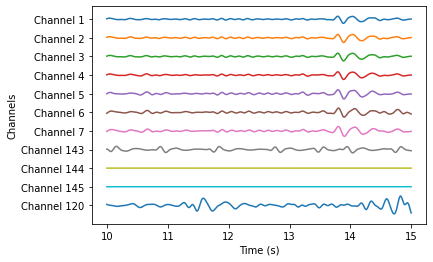

In [7]:
plot_eeg(filtered_signal, downsampled_ts, 10, 5, [1, 2, 3, 4, 5, 6, 7, 143, 144, 145, 120])

In [8]:
stimuli_idx = sig.find_peaks(downsampled_signal[143], distance=10)[0]
#find the timestamps of the stimuli with stimulus_idx in downsampled_ts
stimuli_ts = downsampled_ts[stimuli_idx]

print(stimuli_ts)

[2.700000e-02 5.700000e-02 8.700000e-02 ... 2.526042e+03 2.526072e+03
 2.526102e+03]


In [9]:
def evoked_response_potential(signal, ts, stimuli_idx, channel, lower_bound, upper_bound):
    """
    Calculate the evoked response potential.

    Parameters
    ----------
    signal : ndarray
        Signal to calculate the evoked response potential from.
    ts : ndarray
        Timestamps of the signal.
    stimuli_idx : ndarray
        Indices of the stimuli.
    channel : int
        Channel to calculate the evoked response potential from.
    lower_bound : float
        Lower bound of the time window to calculate the evoked response potential from.
    upper_bound : float
        Upper bound of the time window to calculate the evoked response potential from.

    Returns
    -------
    ndarray
        Evoked response potential.
    """

    stimuli_idx = stimuli_idx[200:300]
    n_stimuli = len(stimuli_idx)
    mean_response = np.zeros(1000)
   
    for stim in stimuli_idx:            
        t = ts[stim]
        start_idx = np.argmin(np.abs(ts - (t - lower_bound)))
        end_idx = np.argmin(np.abs(ts - (t + upper_bound)))

        mean_response = np.add(mean_response, signal[channel, start_idx:end_idx][0:1000])

    return mean_response / n_stimuli


In [10]:
responses = np.empty((127, 1000))

for i in tqdm(range(127)):
    responses[i] = evoked_response_potential(downsampled_signal, downsampled_ts, stimuli_idx, i, 1, 2)

100%|██████████| 127/127 [03:03<00:00,  1.44s/it]


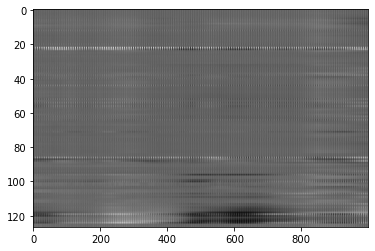

In [11]:
plt.imshow(responses, aspect='auto', cmap='gray')

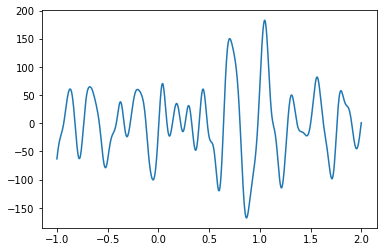

In [12]:
plt.plot(np.linspace(-1, 2, 1000), evoked_response_potential(filtered_signal, downsampled_ts, stimuli_idx, 22, 1, 2))

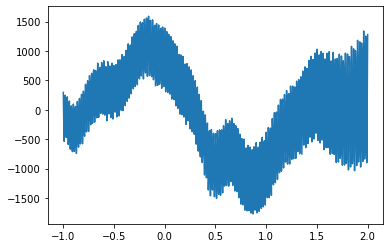

In [14]:
plt.plot(np.linspace(-1, 2, 1000), np.mean(responses[120:127], axis=0))